# BMI for the bionic arm

As a proof of concept we want to show that our bionic arm can replicate the actions performed by the monkey during a trial.

## Imports

In [3]:
#Adding working directory to python path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#Turn off deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
#Import standard packages
import numpy as np
np.random.seed(27) # Seed is important for having the same test set for performance comparison
import pickle as pkl
import json
from utils.functions import *
from math import ceil
import time

#Import tensorflow
import tensorflow as tf
#tf.get_logger().setLevel('ERROR')
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#Import graphics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

#Import function to laod and process dataset
from utils.data_processing import ObjectSelector 
from sklearn.preprocessing import LabelEncoder

# #Import metrics
from sklearn.metrics import accuracy_score, r2_score, log_loss

#Import decoder functions
from utils.decoders import *

## Parameters

In [7]:
FILE = 'MRec40'  # MRec40, ZRec50 or ZRec50_Mini
PLOTS_FOLDER = '../plots/online'
DATASET_PATH = f'../data/Objects Task DL Project/{FILE}.neo.mat' 
BINNED_DATASET_FOLDER = f'../data/Objects Task DL Project/binned'
BINNING_TIME = 0.04

WINDOW = 10 # Sliding window size

## Loading Data

In [8]:
def load_dataset(file_path, bin_length=0.04):
    try:
        binned_trials = np.load(f'{BINNED_DATASET_FOLDER}/{FILE}_binned_trials.npy')
        targets = np.load(f'{BINNED_DATASET_FOLDER}/{FILE}_objs.npy')
        trial_states = np.load(f'{BINNED_DATASET_FOLDER}/{FILE}_states.npy')
        durations = np.load(f'{BINNED_DATASET_FOLDER}/{FILE}_durations.npy')
        print(f'{len(durations[:,0])} good trials, with average duration: {durations[:,0].mean()}s and std: {durations[:,0].std()}s')
        average_bins = round(durations[:,0].mean() / bin_length)
        print(f'Number of bins having average duration {bin_length}s: {average_bins}')

    except IOError:
        from neo.io.neomatlabio import NeoMatlabIO
        from elephant.conversion import BinnedSpikeTrain
        import quantities
        from bisect import bisect

        r = NeoMatlabIO(filename=file_path)
        blk = r.read_block()

        spikes_list = []
        events = []
        targets = []
        durations = []
        discarded = []
        for i, seg in enumerate(blk.segments):  # segments are the individual trials
            # Every run performed by the monkey is checked, and if it is not correct it is ignored
            if seg.annotations['correct'] == 0:
                discarded.append(i)
                continue

            spikes_list.append(seg.spiketrains)  # list of trials in spikelists fashion        
            events.append(seg.events[0])  # list of events associated to each trial
            targets.append(seg.annotations['obj'])   # list of objects associated to each trial

            times = np.array([(spiketrain.t_start, spiketrain.t_stop) for spiketrain in seg.spiketrains])
            t_start = max(events[-1][0], times[:,0].min()*quantities.s)
            t_stop = min(events[-1][-1], times[:,1].max()*quantities.s)

            durations.append((t_stop-t_start, t_start, t_stop))  # list of duration of each trial

        n_seg = i + 1
        kept = n_seg - len(discarded)
        print(f'The dataset contained {n_seg} trials, of which {len(discarded)} were aborted due to monkey mistake')
        durations = np.array(durations)
        mu_t = durations[:,0].mean()
        sigma_t = durations[:,0].std()

        assert kept == len(durations[:,0])
        print(f'{len(durations[:,0])} good trials, with average duration: {mu_t}s and std: {sigma_t}s')
        average_bins = round(mu_t / bin_length)
        print(f'Number of bins having average duration {bin_length}s: {average_bins}')

        binned_trials = []
        trial_states = []
        for j in range(kept):
            binned_trials.append(
                BinnedSpikeTrain(spikes_list[j], 
                                 n_bins=average_bins, 
                                 t_start=durations[j,1]*quantities.s,
                                 t_stop=durations[j,2]*quantities.s
                                ).to_array()
            )
            evt = list(events[j].times)
            labels = events[j].labels
            step = durations[j,0]/average_bins*quantities.s
            trial_states.append(
                [labels[bisect(evt, t) - 1].strip() for t in np.arange(evt[0], evt[-1]+0.001*quantities.s, step)[1:]] 
            )
            assert binned_trials[-1].shape[1] == len(trial_states[-1])
        binned_trials = np.array(binned_trials)
        targets = np.array(targets)
        trial_states = np.array(trial_states)
        np.save(f'{BINNED_DATASET_FOLDER}/{FILE}_binned_trials.npy', binned_trials)
        np.save(f'{BINNED_DATASET_FOLDER}/{FILE}_objs.npy', targets)
        np.save(f'{BINNED_DATASET_FOLDER}/{FILE}_states.npy', trial_states)    
        np.save(f'{BINNED_DATASET_FOLDER}/{FILE}_durations.npy', durations) 
        
    return binned_trials, targets, trial_states

In [9]:
def sliding_window(my_window, my_states, my_shape, my_size, w_size=10):
        p_window = []
        next_state = []
        shape = []
        size = []
        (n_channels, n_steps) = my_window.shape
        for time_step in range(n_steps):
            if time_step < w_size-1:
                sliced_window = np.zeros((n_channels, w_size-time_step-1))
                sliced_window = np.hstack((sliced_window, my_window[:, :time_step+1]))
            else:
                sliced_window = my_window[:, time_step-w_size+1:time_step+1]
                
            p_window.append(sliced_window)
            if time_step == n_steps-1:
                next_state.append('End')
            else:
                next_state.append(my_states[time_step+1].strip())
            shape.append(my_shape)
            size.append(my_size)

        return np.array(p_window), np.array(next_state), np.array(shape), np.array(size)

In [10]:
# DATA LOADING
all_measurements, all_objects, all_states, = load_dataset(DATASET_PATH, BINNING_TIME)
print('Dataset loaded: ', all_measurements.shape, '\n')

selector = ObjectSelector()
new_classes = selector.get_non_special(group_labels=True)
labels = [x[1] for x in new_classes]
print('Classes to keep: ', labels)
ids_to_keep = []
for (elements, macro_class) in new_classes:
    print(f'    {macro_class} - {elements}')
    ids_to_keep.append(elements)

ids_to_keep = np.hstack(ids_to_keep)
indices = np.isin(all_objects, ids_to_keep)
print(f'\n{sum(indices)} trials kept', end=' - ')

all_measurements = all_measurements[indices]
all_objects = all_objects[indices]
all_states = all_states[indices]

unique_obj, n_repetition = np.unique(all_objects, return_counts=True, axis=0)

# PRE-PROCESSING
# Sort
n_meas = all_measurements.shape[0]
rnd = np.random.permutation(n_meas)
all_measurements = all_measurements[rnd]
all_objects = all_objects[rnd]
all_states = all_states[rnd]

# Split each class into sets
train_frac = 0.7

train_elems = []
val_elems = []
test_elems = []

for (obj, rep) in zip(unique_obj, n_repetition):
    obj_locations = np.where(all_objects == int(obj))[0]
    train_objs = int(rep*train_frac)
    val_objs = round((rep-train_objs)/2)

    train_elems.append(obj_locations[:train_objs])
    val_elems.append(obj_locations[train_objs:train_objs+val_objs])
    test_elems.append(obj_locations[train_objs+val_objs:])

train_elems = np.hstack(train_elems)
val_elems = np.hstack(val_elems)
test_elems = np.hstack(test_elems)

print(f'(train: {len(train_elems)}, validation: {len(val_elems)}, test: {len(test_elems)})\n')

p_window = {'train': [], 'validation': [], 'test': []}
trial_state = {'train': [], 'validation': [], 'test': []}
obj_shape = {'train': [], 'validation': [], 'test': []}
obj_size = {'train': [], 'validation': [], 'test': []}

test_dict = {}
start_t = time.time()
for i in progressbar(range(n_meas), "Applying sliding window transformation: ", 80):
    obj = all_objects[i]
    label = labels[int(str(obj)[0]) - 2]
    a, b, c, d = sliding_window(all_measurements[i], all_states[i], label, str(obj)[1], w_size=WINDOW)
    if i in train_elems:
        key = 'train'
    elif i in val_elems:
        key = 'validation'
    elif i in test_elems:
        key = 'test'
        if not obj in test_dict.keys():
            test_dict[obj] = {
                'trial': all_measurements[i],
                'states': all_states[i],
                'shape': label,
                'size': str(obj)[1],
            }
    else:
        print(f'ERROR: element {i} in none of the sets lists')

    p_window[key].append(a)
    trial_state[key].append(b)
    obj_shape[key].append(c)
    obj_size[key].append(d)
print(f'{round(time.time()-start_t, 3)}s')

print('\n###\n    Reshaping..', end='  ')
start_t = time.time()
for key in ['train', 'validation', 'test']:
    #rnd = np.random.permutation(len(obj_shape[key]) * len(obj_shape[key][0]))
    p_window[key] = np.vstack(p_window[key])#.astype('int32')[rnd]
    trial_state[key] = np.hstack(trial_state[key])#[rnd]
    obj_shape[key] = np.hstack(obj_shape[key])#[rnd]
    obj_size[key] = np.hstack(obj_size[key])#[rnd]
print(f'[{round(time.time()-start_t, 3)}s]')

print('    Saving..', end='     ')
start_t = time.time()
# pkl.dump(p_window, open(f'../data/online/p_window_{WINDOW}.pkl', "wb"))
# pkl.dump(trial_state, open(f'../data/online/trial_state_{WINDOW}.pkl', "wb"))
# pkl.dump(obj_shape, open(f'../data/online/obj_shape_{WINDOW}.pkl', "wb"))
# pkl.dump(obj_size, open(f'../data/online/obj_size_{WINDOW}.pkl', "wb"))
# pkl.dump(test_dict, open(f'../data/online/test_dict.pkl', "wb"))
print(f'[{round(time.time()-start_t, 3)}s]\n###')
print('\nFinished!')

for key in ['train', 'validation', 'test']:
    print(key, ': ', p_window[key].shape, trial_state[key].shape, obj_shape[key].shape, obj_size[key].shape)

628 good trials, with average duration: 5.5703993811728845s and std: 0.7236103431406848s
Number of bins having average duration 0.04s: 139
Dataset loaded:  (628, 552, 139) 

Classes to keep:  ['rings', 'cubes', 'balls', 'hCylinder', 'boxes', 'vCylinder']
    rings - ['21', '22', '23', '24', '25', '26']
    cubes - ['31', '32', '33', '34', '35', '36']
    balls - ['41', '42', '43', '44', '45', '46']
    hCylinder - ['51', '52', '53', '54', '55', '56', '57', '58']
    boxes - ['61', '62', '63', '64', '65', '66']
    vCylinder - ['71', '72', '73', '74', '75', '76']

432 trials kept - (train: 288, validation: 72, test: 72)

Applying sliding window transformation: [################################################################################] 432/432
1.021s

###
    Reshaping..  [0.604s]
    Saving..     [0.0s]
###

Finished!
train :  (40032, 552, 10) (40032,) (40032,) (40032,)
validation :  (10008, 552, 10) (10008,) (10008,) (10008,)
test :  (10008, 552, 10) (10008,) (10008,) (10008,)


## Plotting functions

In [11]:
def display_dataset_distribution(unique_class, n_repetition, class_name='classes', save=True):
    fig, ax = plt.subplots(figsize = (18 - (36-len(unique_class))*8/31, 5))
    rects = ax.bar(list(range(len(unique_class))), n_repetition, alpha=0.7)
    ax.set_xticks(list(range(len(unique_class))))
    ax.set_xticklabels(unique_class)

    ax.set_ylim([0, max(n_repetition)*1.15])
    ax.axhline(y=n_repetition.mean(), color='midnightblue', linestyle='-', label='mean', lw=1)
    ax.axhspan(n_repetition.mean()-n_repetition.std(), n_repetition.mean()+n_repetition.std(), alpha=0.4, color='orange', label='std')
    ax.set_xlabel('class', fontsize=12)
    ax.set_ylabel('repetitions', fontsize=12)
    ax.set_title(f'Distribution of {class_name} examples in the dataset', fontsize=14)
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
    plt.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.96], pad=3.0)
    if save:
        fig.savefig(f'{PLOTS_FOLDER}/{class_name.replace(" ", "_")}_distribution.png')
    plt.show()

In [12]:
def display_training_phase(history, network_name='Network', save=True):    
    fig = plt.figure(figsize=(16, 6))
    fig.suptitle(f'{network_name} training phase', fontsize=16)
    gs = gridspec.GridSpec(nrows=1, ncols=2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title('Loss trend in training phase', fontsize=14)
    ax1.plot(history.history['loss'], label='training set')
    ax1.plot(history.history['val_loss'], label='validation set')
    ax1.legend()
    ax1.set_xlabel('epoch', fontsize=12)
    ax1.set_ylabel('cross entropy loss', fontsize=12)

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title('Accuracy trend in training phase', fontsize=14)
    ax2.plot(history.history['accuracy'], label='training set')
    ax2.plot(history.history['val_accuracy'], label='validation set')
    ax2.legend()
    ax2.set_xlabel('epoch', fontsize=12)
    ax2.set_ylabel('accuracy', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96], pad=3.0)
    if save:
        fig.savefig(f'{PLOTS_FOLDER}/{network_name.replace(" ", "_").lower()}_training_history.png')
    plt.show()

In [13]:
def display_testing_phase_results(conf_matrix, my_labels, errors_distribution, network_name='network', save=True):
    fig = plt.figure(figsize=(14, 9))
    fig.suptitle(f'Performances of {network_name} testing', fontsize=16)
    gs = gridspec.GridSpec(nrows=3, ncols=3)

    ax1 = fig.add_subplot(gs[:, :-1])
    ax1.set_title('Confusion matrix', fontsize=14)
    conf_matrix_norm = normalize(conf_matrix, axis=1, norm='l1')
    im = ax1.imshow(conf_matrix_norm, cmap=sns.cubehelix_palette(as_cmap=True, light=.95, gamma=0.75), vmin=0, vmax=1)

    ax1.vlines([i + 0.5 for i in range(n_outputs)], -0.5, n_outputs - 0.5, linewidth=2, colors='White')
    ax1.hlines([i + 0.5 for i in range(n_outputs)], -0.5, n_outputs - 0.5, linewidth=2, colors='White')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    rows, columns = conf_matrix.shape
    for i in range(rows):
        for j in range(columns):
            c = conf_matrix[i][j]
            if c > 0:
                color = 'White' if conf_matrix_norm[i][j]>=.65 else 'Black'
                ax1.text(j, i, str(round(c,0)), va='center', ha='center', c=color, fontsize=12)
    ax1.set_xticks(list(range(n_outputs)))
    ax1.set_yticks(list(range(n_outputs)))
    ax1.set_xticklabels(my_labels)
    ax1.set_yticklabels(my_labels)
    ax1.set_ylabel('true value', fontsize=12)
    ax1.set_xlabel('prediction', fontsize=12)

    ax2 = fig.add_subplot(gs[0, -1])
    ax2.set_title('Distance from the diagonal', fontsize=14)
    x = list(errors_distribution.keys())
    x.sort()
    y = [errors_distribution[distance] for distance in x]
    ax2.step(x, y, where='mid', c='midnightblue')
    ax2.axvspan(-1.5, 1.5, alpha=0.4, color='palevioletred')
    x_max = min(max(list(errors_distribution.keys())), 10)
    lim = x_max if x_max%2 == 0 else x_max-1
    lim = min(lim, 10)
    ax2.set_xticks(list(range(-lim, lim+2, 2)))
    ax2.set_xlim(-x_max, x_max)
    ax2.set_yscale('log')
    ax2.set_ylabel('n errors', fontsize=12)
    ax2.set_xlabel('distance', fontsize=12, y=-10)
    
    e0 = errors_distribution[0]
    e1 = errors_distribution[1]+errors_distribution[-1]
    
    ax3 = fig.add_subplot(gs[1, -1])
    ax3.axis('off')
    ax3.text(0,0.9,f'Distance 0: {round(e0, 3)} [{round(e0/len(y_test)*100, 1)}%]', fontsize=11.5)
    ax3.text(0,0.8,f'Distance ±1: {round(e0+e1, 3)} [{round((e0+e1)/len(y_test)*100, 1)}%]', fontsize=11.5)


    plt.tight_layout(rect=[0, 0, 1, 0.96], pad=3.0)
    if save:
        fig.savefig(f'{PLOTS_FOLDER}/{network_name.replace(" ", "_")}_testing_results.png')
    plt.show()

# PART 1: recognise shape
The first task is that of recognizing only the shape of the object; I will proceed checking whether the dataset is balanced and then training the network

#### Training dataset analysis


Object shape repetitions in the training dataset:
('balls', 2614)   ('boxes', 2694)   ('cubes', 2506)   ('hCylinder', 2493)   ('rings', 2462)   ('vCylinder', 2450)   [Tot: 15219]


Dataset internal variation [88.192] is 3.0% of the average classes representation [2536.0]: 
	Balanced!


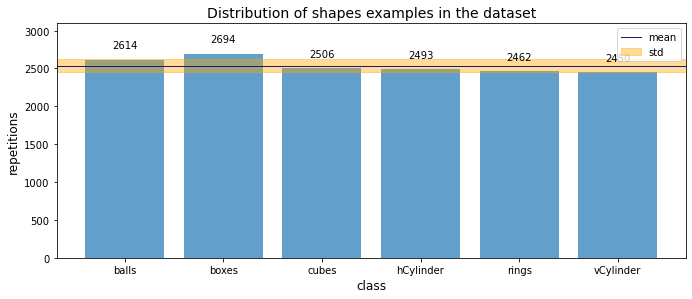

In [73]:
# Splitting Sets
x_train = p_window['train'][np.isin(trial_state['train'], ['Cue', 'Mem', 'React', 'Go'])]
y_train = obj_shape['train'][np.isin(trial_state['train'], ['Cue', 'Mem', 'React', 'Go'])]
x_val = p_window['validation'][np.isin(trial_state['validation'], ['Cue', 'Mem', 'React', 'Go'])]
y_val = obj_shape['validation'][np.isin(trial_state['validation'], ['Cue', 'Mem', 'React', 'Go'])]
x_test = p_window['test'][np.isin(trial_state['test'], ['Cue', 'Mem', 'React', 'Go'])]
y_test = obj_shape['test'][np.isin(trial_state['test'], ['Cue', 'Mem', 'React', 'Go'])]

unique_shapes, n_repetition = np.unique(y_train, return_counts=True, axis=0)
print('\nObject shape repetitions in the training dataset:' )
for elem in zip(unique_shapes, n_repetition):
    print(elem, end='   ')
print(f'[Tot: {sum(n_repetition)}]')

balance = n_repetition.std()/n_repetition.mean()*100
print(f'\n\nDataset internal variation [{round(n_repetition.std(), 3)}] is {round(balance, 0)}% of the average classes representation [{round(n_repetition.mean(), 0)}]: \n\t{"Balanced!" if round(balance) <= 10 else "Not balanced!"}')

display_dataset_distribution(unique_shapes, n_repetition, 'shapes')

#### Data preprocessing

In [75]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

(_, n_channels, n_steps) = x_train.shape

shape_encoder = LabelEncoder()
y_train = tf.keras.utils.to_categorical(shape_encoder.fit_transform(y_train))
y_val = tf.keras.utils.to_categorical(shape_encoder.transform(y_val))
y_test = tf.keras.utils.to_categorical(shape_encoder.transform(y_test))

(_, n_outputs) = y_train.shape

pkl.dump(scaler, open(f'../results/online/shape_scaler.pkl', "wb"))
pkl.dump(shape_encoder, open(f'../results/online/shape_encoder.pkl', "wb"))

print(f'X || Train: {x_train.shape} -- Validation: {x_val.shape} -- Test: {x_test.shape}')
print(f'Y || Train: {y_train.shape} -- Validation: {y_val.shape} -- Test: {y_test.shape}')

X || Train: (15219, 552, 10) -- Validation: (3781, 552, 10) -- Test: (3739, 552, 10)
Y || Train: (15219, 6) -- Validation: (3781, 6) -- Test: (3739, 6)


#### Training phase

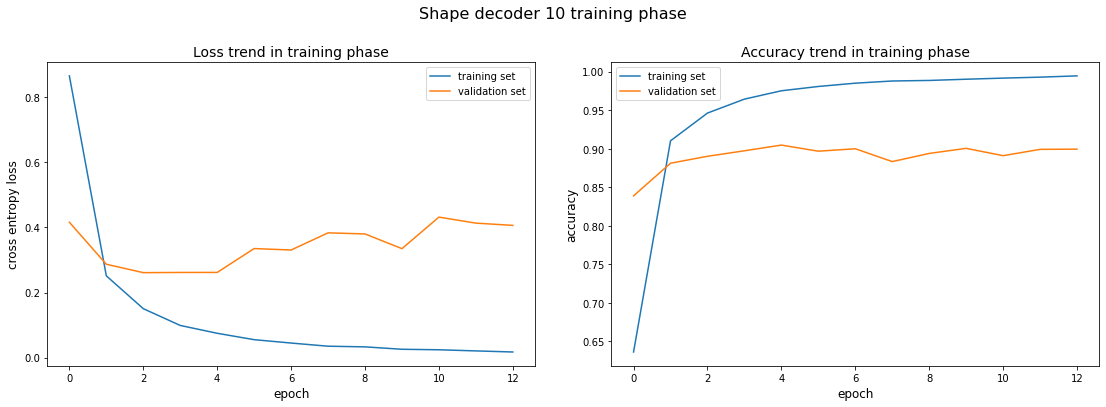

In [77]:
# Loading hyperparameters
with open('../utils/hyperparameters.json', 'r') as f:
    config_dict = json.load(f)
params = config_dict['ensemble']

# Building network
network = Ensemble(n_channels, n_outputs,
                   filters=int(params['n_filters']), 
                   filters_size=int(params['size']), 
                   activation=params['activation'],
                   dropout=params['frac_dropout_1'], 
                   pooling_layer=params['pooling_layer'], 
                   recurrent_layer=params['recurrent_layer'], 
                   recurrent_dropout=params['frac_dropout_2'],
                   units=int(params['n_units']),
                   neurons=params['n_neurons'],
                   lr=0.0001)


# Training
history = network.fit(x_train, y_train, x_val, y_val, num_epochs=100, batch_size=int(params['batch_size']), verbose=0)
network.model.save(f'../results/online/shape_decoder_{WINDOW}.h5')

# Displaying
display_training_phase(history, f'Shape decoder {WINDOW}')

#### Testing phase

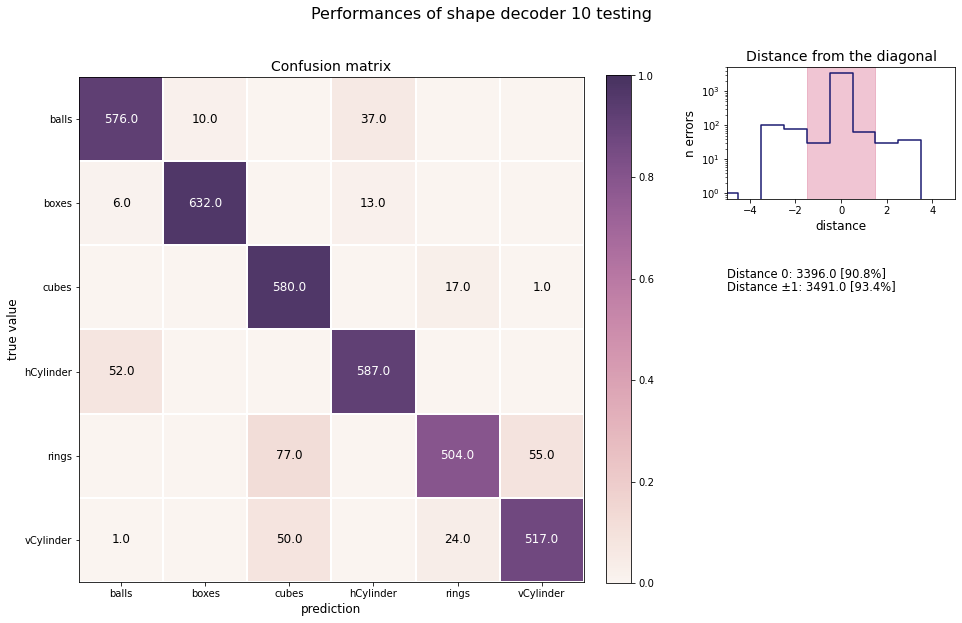

In [79]:
# Loading trained model
network = tf.keras.models.load_model(f'../results/online/shape_decoder_{WINDOW}.h5')

# Predicting
prediction = network.predict(x_test)

# Metrics
conf_matrix, my_labels = my_confusion_matrix(shape_encoder.inverse_transform(prediction.argmax(axis=1)), shape_encoder.inverse_transform(y_test.argmax(axis=1)), labels=shape_encoder.classes_, return_labels=True)
errors_distribution = distance_from_diagonal(conf_matrix)

# Displaying
display_testing_phase_results(conf_matrix, my_labels, errors_distribution, f'shape decoder {WINDOW}')

# PART2: recognise size
The second task is that of recognizing only the size of the object; I will proceed checking whether the dataset is balanced and then training the network

#### Dataset analysis


Object size repetitions in the dataset:
('1', 2598)   ('2', 2569)   ('3', 2471)   ('4', 2488)   ('5', 2546)   ('6', 2547)   

Dataset internal variation [44.124] is 2.0% of the average classes representation [2536.0]: 
	Balanced!


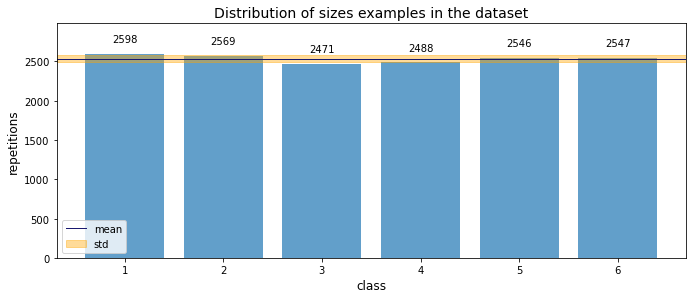

In [80]:
# Splitting Sets
x_train = p_window['train'][np.isin(trial_state['train'], ['Cue', 'Mem', 'React', 'Go'])]
y_train = obj_size['train'][np.isin(trial_state['train'], ['Cue', 'Mem', 'React', 'Go'])]
x_val = p_window['validation'][np.isin(trial_state['validation'], ['Cue', 'Mem', 'React', 'Go'])]
y_val = obj_size['validation'][np.isin(trial_state['validation'], ['Cue', 'Mem', 'React', 'Go'])]
x_test = p_window['test'][np.isin(trial_state['test'], ['Cue', 'Mem', 'React', 'Go'])]
y_test = obj_size['test'][np.isin(trial_state['test'], ['Cue', 'Mem', 'React', 'Go'])]

unique_sizes, n_repetition = np.unique(y_train, return_counts=True, axis=0)
print('\nObject size repetitions in the dataset:' )
for elem in zip(unique_sizes, n_repetition):
    print(elem, end='   ')
    
balance = n_repetition.std()/n_repetition.mean()*100
print(f'\n\nDataset internal variation [{round(n_repetition.std(), 3)}] is {round(balance, 0)}% of the average classes representation [{round(n_repetition.mean(), 0)}]: \n\t{"Balanced!" if round(balance) <= 10 else "Not balanced!"}')

display_dataset_distribution(unique_sizes, n_repetition, 'sizes')

#### Data preprocessing
Windows must be normalized and target value one-hot encoded

In [81]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

(_, n_channels, n_steps) = x_train.shape

size_encoder = LabelEncoder()
y_train = tf.keras.utils.to_categorical(size_encoder.fit_transform(y_train))
y_val = tf.keras.utils.to_categorical(size_encoder.transform(y_val))
y_test = tf.keras.utils.to_categorical(size_encoder.transform(y_test))

(_, n_outputs) = y_train.shape

pkl.dump(scaler, open(f'../results/online/size_scaler.pkl', "wb"))
pkl.dump(size_encoder, open(f'../results/online/size_encoder.pkl', "wb"))

print(f'X || Train: {x_train.shape} -- Validation: {x_val.shape} -- Test: {x_test.shape}')
print(f'Y || Train: {y_train.shape} -- Validation: {y_val.shape} -- Test: {y_test.shape}')

X || Train: (15219, 552, 10) -- Validation: (3781, 552, 10) -- Test: (3739, 552, 10)
Y || Train: (15219, 6) -- Validation: (3781, 6) -- Test: (3739, 6)


#### Training phase

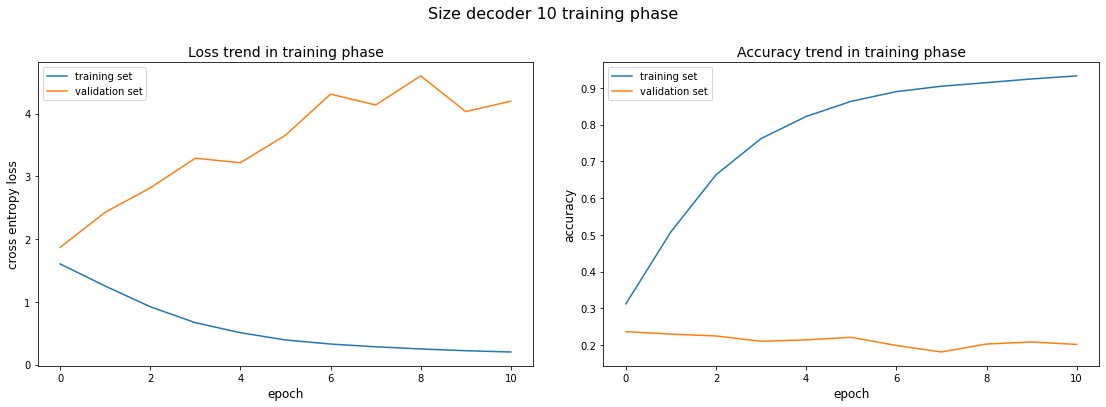

In [82]:
# Loading hyperparameters
with open('../utils/hyperparameters.json', 'r') as f:
    config_dict = json.load(f)
params = config_dict['ensemble']

# Building network
network = Ensemble(n_channels, n_outputs,
                   filters=int(params['n_filters']), 
                   filters_size=int(params['size']), 
                   activation=params['activation'],
                   dropout=params['frac_dropout_1'], 
                   pooling_layer=params['pooling_layer'], 
                   recurrent_layer=params['recurrent_layer'], 
                   recurrent_dropout=params['frac_dropout_2'],
                   units=int(params['n_units']),
                   neurons=params['n_neurons'])

# Training
history = network.fit(x_train, y_train, x_val, y_val, num_epochs=100, batch_size=int(params['batch_size']), verbose=0)
network.model.save(f'../results/online/size_decoder_{WINDOW}.h5')

# Displaying
display_training_phase(history, f'Size decoder {WINDOW}')

#### Testing phase

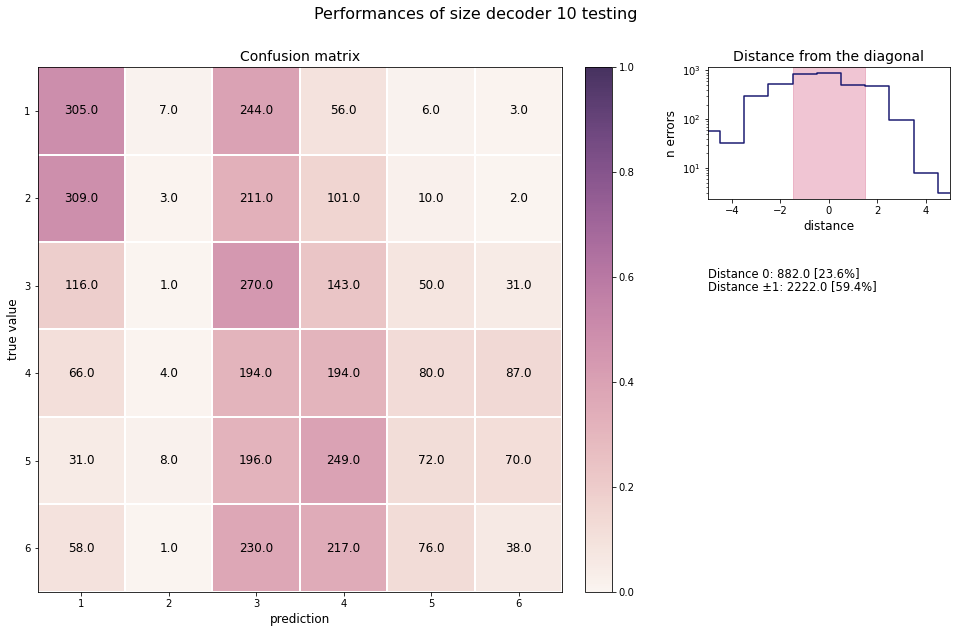

In [83]:
# Loading trained model
network = tf.keras.models.load_model(f'../results/online/size_decoder_{WINDOW}.h5')

# Predicting
prediction = network.predict(x_test)

# Metrics
conf_matrix, my_labels = my_confusion_matrix(size_encoder.inverse_transform(prediction.argmax(axis=1)), size_encoder.inverse_transform(y_test.argmax(axis=1)), labels=size_encoder.classes_, return_labels=True)
errors_distribution = distance_from_diagonal(conf_matrix)

# Displaying
display_testing_phase_results(conf_matrix, my_labels, errors_distribution, f'size decoder {WINDOW}')

# PART3: recognise epoch
The last task is that of predicting the next trial phase; I will proceed checking whether the dataset is balanced and then training the network

#### Dataset analysis

['Start', 'Rest']  not present after sliding window processing

Trial states repetitions in the dataset:
('Motor', 9235) ('FixLOn', 1638) ('Fix', 4603) ('Cue', 4955) ('Mem', 5680) ('React', 325) ('Go', 4259) ('Hold', 3540) ('Rew', 411) ('Intert', 4950) ('End', 436) [Tot: 40032]


Dataset internal variation [2627.144] is 72.0% of the average classes representation [3639.0]: 
	Not balanced!


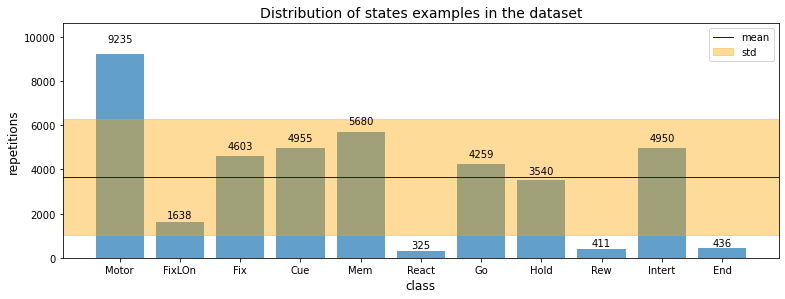

In [18]:
# Splitting Sets
x_train = p_window['train']
y_train = trial_state['train']
x_val = p_window['validation']
y_val = trial_state['validation']
x_test = p_window['test']
y_test = trial_state['test']

unique_states, n_repetition = np.unique(y_train, return_counts=True, axis=0)

# Reordering the labels to match the chronological order of phases instead of the alphabetical one
states_order = []
ordered_states = ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix', 'Cue', 'Mem', 'React', 'Go', 'Hold', 'Rew', 'Intert', 'End']
missing = []
for ep in ordered_states:
    try:
        states_order.append(list(unique_states).index(ep))
    except ValueError:
        missing.append(ep)
print(missing, ' not present after sliding window processing')
        
print('\nTrial states repetitions in the dataset:' )
for elem in zip(unique_states[states_order], n_repetition[states_order]):
    print(elem, end=' ')

print(f'[Tot: {sum(n_repetition)}]')

balance = n_repetition.std()/n_repetition.mean()*100
print(f'\n\nDataset internal variation [{round(n_repetition.std(), 3)}] is {round(balance, 0)}% of the average classes representation [{round(n_repetition.mean(), 0)}]: \n\t{"Balanced!" if balance < 10 else "Not balanced!"}')

display_dataset_distribution(unique_states[states_order], n_repetition[states_order], 'states')

#### Addressing unbalancement


Trial states repetitions after grouping:
('Waiting', 15476) ('Cue', 4955) ('Planning', 5680) ('Movement', 4584) ('Hold', 3951) ('End', 5386) [Tot: 40032]


Dataset internal variation [3976.178] is 60.0% of the average classes representation [6672.0]: 
	Not balanced!


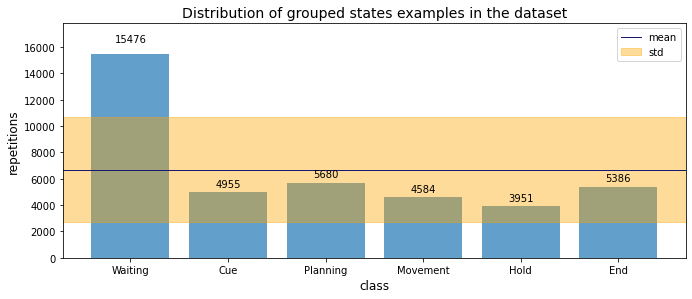

In [19]:
fixation = 0
cue = 0
planning = 0
movement = 0
hold = 0
end = 0

for elem in zip(unique_states[states_order], n_repetition[states_order]):
    if elem[0] in ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix']:
        fixation += elem[1]
    elif elem[0] in ['Cue']:
        cue += elem[1]
    elif elem[0] in ['Mem']:
        planning += elem[1]
    elif elem[0] in ['React', 'Go']:
        movement += elem[1]
    elif elem[0] in ['Hold', 'Rew']:
        hold += elem[1]
    elif elem[0] in ['Intert', 'End']:
        end += elem[1]

new_states = ['Waiting', 'Cue', 'Planning', 'Movement', 'Hold', 'End']
new_repetitions = np.array([fixation, cue, planning, movement, hold, end])

#my_cap = find_cap_to_balance(new_repetitions, 10)
#new_repetitions = np.array([rep if rep <= my_cap else my_cap for rep in new_repetitions])

print('\nTrial states repetitions after grouping:' )
for elem in zip(new_states, new_repetitions):
    print(elem, end=' ')

print(f'[Tot: {sum(n_repetition)}]')

balance = new_repetitions.std()/new_repetitions.mean()*100
print(f'\n\nDataset internal variation [{round(new_repetitions.std(), 3)}] is {round(balance, 0)}% of the average classes representation [{round(new_repetitions.mean(), 0)}]: \n\t{"Balanced!" if balance < 10 else "Not balanced!"}')

display_dataset_distribution(new_states, new_repetitions, 'grouped states')

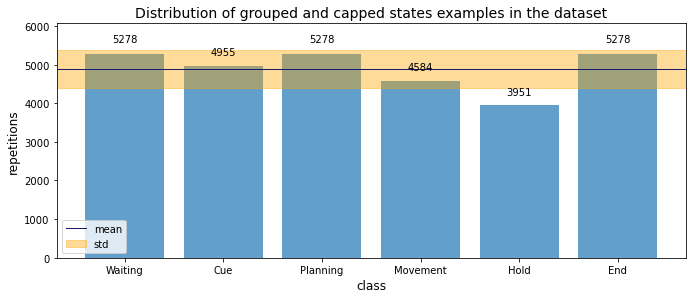

In [20]:
# Evaluating the minimum cap to guarantee a balance margin of 10%
my_cap = find_cap_to_balance(new_repetitions, 10)
new_repetitions = np.array([rep if rep <= my_cap else my_cap for rep in new_repetitions])
display_dataset_distribution(new_states, new_repetitions, 'grouped and capped states')

# Relabeling all the y in the dataset and keep only {cap} of each one
# 'Waiting', 'Cue', 'Planning', 'Movement', 'Hold', 'End'
phase_dict = {
    'Waiting': np.where(np.isin(y_train, ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix']))[0],
    'Cue': np.where(np.isin(y_train, ['Cue']))[0],
    'Planning': np.where(np.isin(y_train, ['Mem']))[0],
    'Movement': np.where(np.isin(y_train, ['React', 'Go']))[0],
    'Hold': np.where(np.isin(y_train, ['Hold', 'Rew']))[0],
    'End': np.where(np.isin(y_train, ['Intert', 'End']))[0]
}

x_train_balanced = []
y_train_balanced = []

for phase, new_rep in zip(new_states, new_repetitions): #important to read them in chronological order
    phase_idx = phase_dict[phase]
    to_keep = min(my_cap, new_rep)
    x_train_balanced.append(x_train[phase_idx][:to_keep])
    y_train_balanced.append([phase]*to_keep)
    
x_train_balanced = np.vstack(x_train_balanced).astype('int32')
y_train_balanced = np.hstack(y_train_balanced)

rnd = np.random.permutation(len(y_train_balanced))
x_train = x_train_balanced[rnd]
y_train = y_train_balanced[rnd]

In [21]:
# apply grouping to other sets
phase_dict = {
    'Waiting': np.where(np.isin(y_val, ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix']))[0],
    'Cue': np.where(np.isin(y_val, ['Cue']))[0],
    'Planning': np.where(np.isin(y_val, ['Mem']))[0],
    'Movement': np.where(np.isin(y_val, ['React', 'Go']))[0],
    'Hold': np.where(np.isin(y_val, ['Hold', 'Rew']))[0],
    'End': np.where(np.isin(y_val, ['Intert', 'End']))[0]
}

x_val_balanced = []
y_val_balanced = []

for phase in new_states: #important to read them in chronological order
    phase_idx = phase_dict[phase]
    x_val_balanced.append(x_val[phase_idx])
    y_val_balanced.append([phase]*len(phase_idx))
    
x_val_balanced = np.vstack(x_val_balanced).astype('int32')
y_val_balanced = np.hstack(y_val_balanced)

rnd = np.random.permutation(len(y_val_balanced))
x_val = x_val_balanced[rnd]
y_val = y_val_balanced[rnd]

####
phase_dict = {
    'Waiting': np.where(np.isin(y_test, ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix']))[0],
    'Cue': np.where(np.isin(y_test, ['Cue']))[0],
    'Planning': np.where(np.isin(y_test, ['Mem']))[0],
    'Movement': np.where(np.isin(y_test, ['React', 'Go']))[0],
    'Hold': np.where(np.isin(y_test, ['Hold', 'Rew']))[0],
    'End': np.where(np.isin(y_test, ['Intert', 'End']))[0]
}

x_test_balanced = []
y_test_balanced = []

for phase in new_states: #important to read them in chronological order
    phase_idx = phase_dict[phase]
    x_test_balanced.append(x_test[phase_idx])
    y_test_balanced.append([phase]*len(phase_idx))
    
x_test_balanced = np.vstack(x_test_balanced).astype('int32')
y_test_balanced = np.hstack(y_test_balanced)

rnd = np.random.permutation(len(y_test_balanced))
x_test = x_test_balanced[rnd]
y_test = y_test_balanced[rnd]

#### Data preprocessing
Windows must be normalized and target value one-hot encoded

In [22]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

(_, n_channels, n_steps) = x_train.shape

state_encoder = LabelEncoder()
y_train = tf.keras.utils.to_categorical(state_encoder.fit_transform(y_train))
y_val = tf.keras.utils.to_categorical(state_encoder.transform(y_val))
y_test = tf.keras.utils.to_categorical(state_encoder.transform(y_test))

(_, n_outputs) = y_train.shape

pkl.dump(scaler, open(f'../results/online/state_scaler.pkl', "wb"))
pkl.dump(state_encoder, open(f'../results/online/state_encoder.pkl', "wb"))

print(f'X || Train: {x_train.shape} -- Validation: {x_val.shape} -- Test: {x_test.shape}')
print(f'Y || Train: {y_train.shape} -- Validation: {y_val.shape} -- Test: {y_test.shape}')

X || Train: (29324, 552, 10) -- Validation: (10008, 552, 10) -- Test: (10008, 552, 10)
Y || Train: (29324, 6) -- Validation: (10008, 6) -- Test: (10008, 6)


#### Training phase

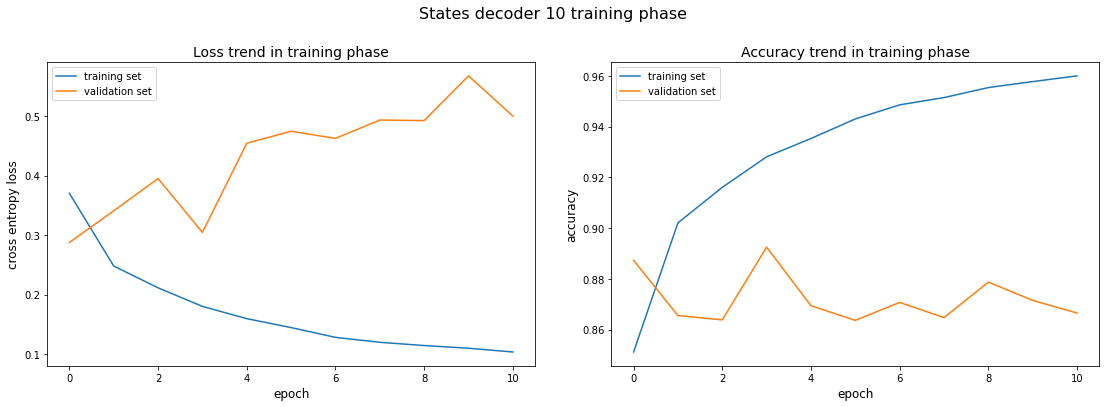

In [23]:
# Loading hyperparameters
with open('../utils/hyperparameters.json', 'r') as f:
    config_dict = json.load(f)
params = config_dict['ensemble']

# Building network
network = Ensemble(n_channels, n_outputs,
                   filters=int(params['n_filters']), 
                   filters_size=int(params['size']), 
                   activation=params['activation'],
                   dropout=params['frac_dropout_1'], 
                   pooling_layer=params['pooling_layer'], 
                   recurrent_layer=params['recurrent_layer'], 
                   recurrent_dropout=params['frac_dropout_2'],
                   units=int(params['n_units']),
                   neurons=params['n_neurons'])

# Training
history = network.fit(x_train, y_train, x_val, y_val, num_epochs=100, batch_size=int(params['batch_size']), verbose=0)
network.model.save(f'../results/online/state_decoder_{WINDOW}.h5')

# Displaying
display_training_phase(history, f'States decoder {WINDOW}')

## Testing phase

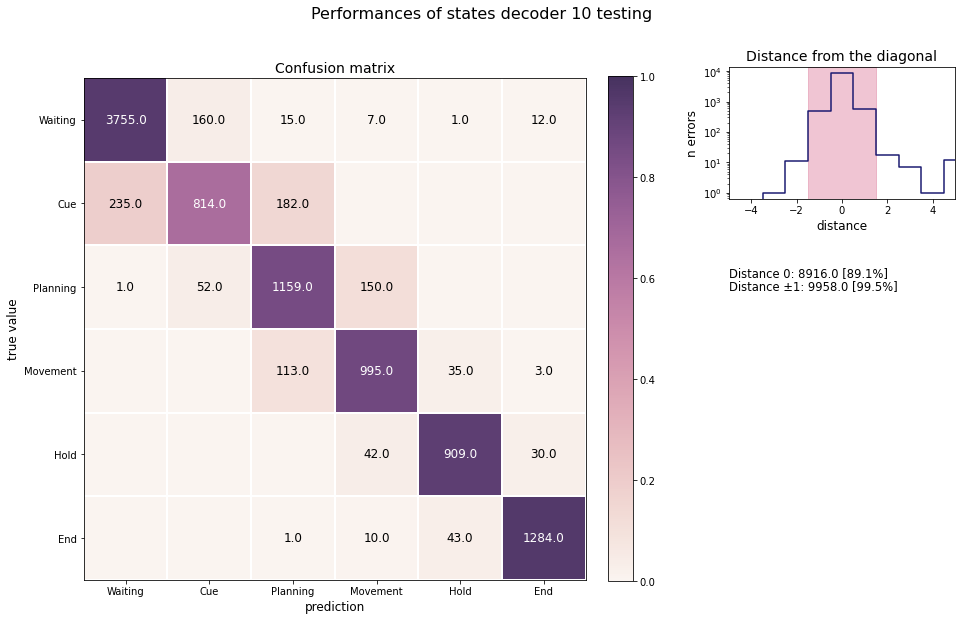

In [24]:
# Loading trained model
network = tf.keras.models.load_model(f'../results/online/state_decoder_{WINDOW}.h5')

# Predicting
prediction = network.predict(x_test)

# Metrics
conf_matrix, my_labels = my_confusion_matrix(state_encoder.inverse_transform(prediction.argmax(axis=1)), state_encoder.inverse_transform(y_test.argmax(axis=1)), labels=new_states, return_labels=True)
errors_distribution = distance_from_diagonal(conf_matrix)

# Displaying
display_testing_phase_results(conf_matrix, my_labels, errors_distribution, f'states decoder {WINDOW}')